In [2]:

!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0, Total reward: 10.0


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Saved video: ./a2c_videos/episode_0.mp4
Episode 10, Total reward: 25.0
Episode 20, Total reward: 19.0
Episode 30, Total reward: 10.0
Episode 40, Total reward: 14.0


Episode 50, Total reward: 14.0
Saved video: ./a2c_videos/episode_50.mp4
Episode 60, Total reward: 10.0
Episode 70, Total reward: 15.0
Episode 80, Total reward: 20.0
Episode 90, Total reward: 23.0


Episode 100, Total reward: 12.0
Saved video: ./a2c_videos/episode_100.mp4
Episode 110, Total reward: 19.0
Episode 120, Total reward: 13.0
Episode 130, Total reward: 10.0
Episode 140, Total reward: 21.0
Episode 150, Total reward: 12.0


Saved video: ./a2c_videos/episode_150.mp4
Episode 160, Total reward: 25.0
Episode 170, Total reward: 17.0
Episode 180, Total reward: 29.0
Episode 190, Total reward: 84.0


Episode 200, Total reward: 33.0
Saved video: ./a2c_videos/episode_200.mp4
Episode 210, Total reward: 39.0
Episode 220, Total reward: 68.0
Episode 230, Total reward: 74.0
Episode 240, Total reward: 30.0


Episode 250, Total reward: 28.0
Saved video: ./a2c_videos/episode_250.mp4
Episode 260, Total reward: 47.0
Episode 270, Total reward: 26.0
Episode 280, Total reward: 26.0
Episode 290, Total reward: 46.0


Episode 300, Total reward: 34.0
Saved video: ./a2c_videos/episode_300.mp4
Episode 310, Total reward: 33.0
Episode 320, Total reward: 112.0
Episode 330, Total reward: 56.0
Episode 340, Total reward: 27.0
Episode 350, Total reward: 34.0


Saved video: ./a2c_videos/episode_350.mp4
Episode 360, Total reward: 30.0
Episode 370, Total reward: 63.0
Episode 380, Total reward: 55.0
Episode 390, Total reward: 30.0


Episode 400, Total reward: 40.0
Saved video: ./a2c_videos/episode_400.mp4
Episode 410, Total reward: 19.0
Episode 420, Total reward: 45.0
Episode 430, Total reward: 32.0
Episode 440, Total reward: 41.0


Episode 450, Total reward: 91.0
Saved video: ./a2c_videos/episode_450.mp4
Episode 460, Total reward: 75.0
Episode 470, Total reward: 48.0
Episode 480, Total reward: 88.0
Episode 490, Total reward: 49.0


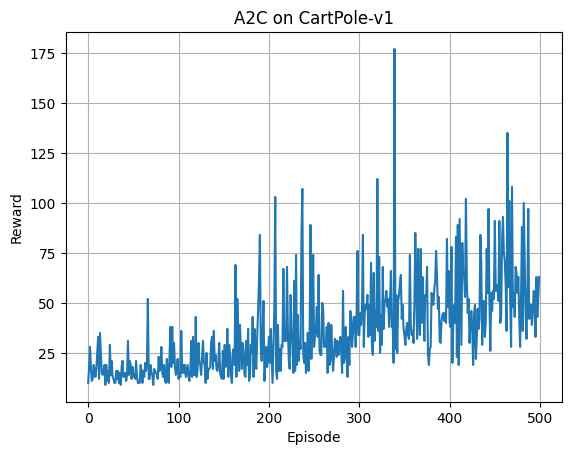

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# --- Настройки ---
ENV_NAME = "CartPole-v1"
GAMMA = 0.99
LR = 1e-3
EPISODES = 500
VIDEO_INTERVAL = 50
SAVE_DIR = "./a2c_videos"
os.makedirs(SAVE_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Актор-Критик модель ---
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
        )
        self.policy = nn.Linear(128, action_dim)
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc(x)
        return self.policy(x), self.value(x)

# --- Обучающий цикл A2C ---
def train(env, model, optimizer):
    reward_history = []

    for episode in range(EPISODES):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []

        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            logits, value = model(state_tensor)
            dist = Categorical(logits=logits)
            action = dist.sample()

            next_state, reward, done, _ = env.step(action.item())

            log_probs.append(dist.log_prob(action))
            values.append(value)
            rewards.append(reward)

            state = next_state
            total_reward += reward

        # Расчет Advantage и возвратов
        Qval = 0
        values.append(torch.tensor([[0.0]]).to(device))  # Bootstrap
        Qvals = []
        for r in reversed(rewards):
            Qval = r + GAMMA * Qval
            Qvals.insert(0, Qval)

        Qvals = torch.tensor(Qvals).float().to(device)
        values = torch.cat(values[:-1])
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values.squeeze()
        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reward_history.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode {episode}, Total reward: {total_reward}")

        if episode % VIDEO_INTERVAL == 0:
            record_video(env, model, episode)

    return reward_history

# --- Запись видео ---
def record_video(env, model, episode):
    frames = []
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        frames.append(frame)

        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        logits, _ = model(state_tensor)
        dist = Categorical(logits=logits)
        action = dist.sample().item()

        state, _, done, _ = env.step(action)

    filename = os.path.join(SAVE_DIR, f"episode_{episode}.mp4")
    imageio.mimsave(filename, frames, fps=30)
    print(f"Saved video: {filename}")

# --- Основной запуск ---
if __name__ == "__main__":
    env = gym.make(ENV_NAME)
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    model = ActorCritic(obs_dim, action_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    rewards = train(env, model, optimizer)

    env.close()

    # --- Визуализация прогресса ---
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("A2C on " + ENV_NAME)
    plt.grid()
    plt.show()
